In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Import and Process Data

In [11]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

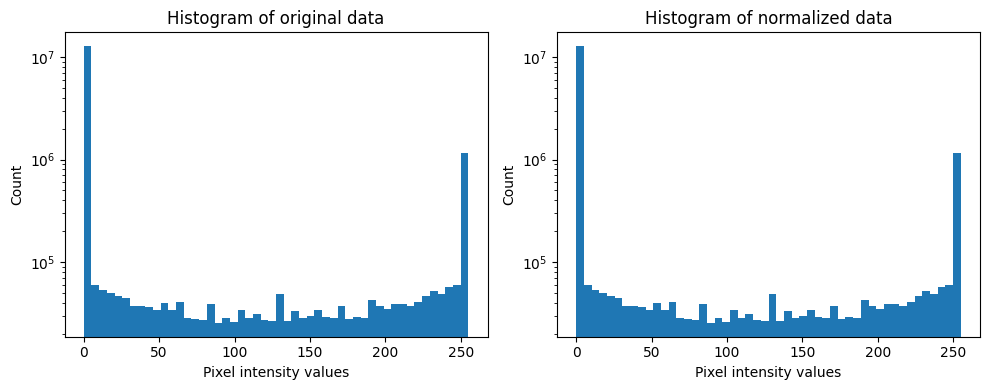

In [12]:
# normalize the data to a range of [0 1]
# dataNorm = data / np.max(data)
dataNorm = data

# print(f'Normalized data range: {dataNorm.min()} to {dataNorm.max()} ')

#binarize the data. Any pixel value > 0 is 1 else 0

# dataNorm = (data > 0).astype(float)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_yscale('log')
ax[1].set_title('Histogram of normalized data')
plt.tight_layout()

plt.show();

# Create train/test datasets using Dataloader

In [24]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

#Normalize train data only
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())

#Normalize test data only
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

print(f'Normalized train data range: {train_data.min()} to {train_data.max()} ')
print(f'Normalized test data range: {test_data.min()} to {test_data.max()} ')

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Normalized train data range: 0.0 to 1.0 
Normalized test data range: 0.0 to 1.0 


# Create ANN/ FFN model

In [25]:
# Define architecture of ANN model
class ANNmodel(nn.Module):
  def __init__(self):
    super().__init__()

    #input layers
    self.input = nn.Linear(784,64)

    #hidden layers
    self.hidden1 = nn.Linear(64,32)
    self.hidden2 = nn.Linear(32,16)

    #output layer
    self.output = nn.Linear(16,10)

  def forward(self,x):
    x = F.relu(self.input(x))
    x = F.relu(self.hidden1(x))
    x = F.relu(self.hidden2(x))
    x = self.output(x)

    return torch.log_softmax(x,axis=1)

In [26]:
# Define the function to create the ANN model
def createANNmodel():

  #instantiate the model
  model = ANNmodel()

  #loss function
  lossfun = nn.NLLLoss()

  #optimizer function
  optimizer = torch.optim.SGD(model.parameters(),lr=.01)

  return model,lossfun,optimizer

In [27]:
# test the model with one batch
model,lossfun,optimizer = createANNmodel()

X,y = next(iter(train_loader))
yHat = model(X)

# values are log-probability of each number (0-9)
print(torch.exp(yHat))

# now let's compute the loss
# loss = lossfun(yHat,y)
# print(' ')
# print('Loss:')
# print(loss)

tensor([[0.0984, 0.0863, 0.1140, 0.0763, 0.1076, 0.0973, 0.0992, 0.0994, 0.1076,
         0.1139],
        [0.0978, 0.0858, 0.1150, 0.0779, 0.1079, 0.0967, 0.1013, 0.0977, 0.1064,
         0.1135],
        [0.0983, 0.0859, 0.1140, 0.0767, 0.1078, 0.0963, 0.0997, 0.0997, 0.1074,
         0.1143],
        [0.0987, 0.0857, 0.1152, 0.0771, 0.1088, 0.0969, 0.0992, 0.0981, 0.1069,
         0.1136],
        [0.0990, 0.0865, 0.1141, 0.0767, 0.1080, 0.0973, 0.0990, 0.0985, 0.1072,
         0.1136],
        [0.0991, 0.0851, 0.1147, 0.0775, 0.1094, 0.0957, 0.0987, 0.0989, 0.1073,
         0.1137],
        [0.0976, 0.0852, 0.1141, 0.0771, 0.1100, 0.0957, 0.1007, 0.0990, 0.1072,
         0.1134],
        [0.0997, 0.0861, 0.1120, 0.0762, 0.1087, 0.0963, 0.0984, 0.1005, 0.1073,
         0.1149],
        [0.0977, 0.0858, 0.1149, 0.0777, 0.1084, 0.0951, 0.1003, 0.0985, 0.1072,
         0.1142],
        [0.0987, 0.0860, 0.1143, 0.0772, 0.1081, 0.0963, 0.0991, 0.0988, 0.1072,
         0.1143],
        [0

# Train the model

In [28]:
# a function that trains the model

def trainANNmodel(numepochs=60):


  # create a new model
  net,lossfun,optimizer = createANNmodel()

  # initialize losses
  losses    = torch.zeros((numepochs,2))
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi,0] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    loss = lossfun(yHat,y)
    losses[epochi,1] = loss.item()

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model

In [29]:
trainAcc,testAcc,losses,model = trainANNmodel(numepochs=60)

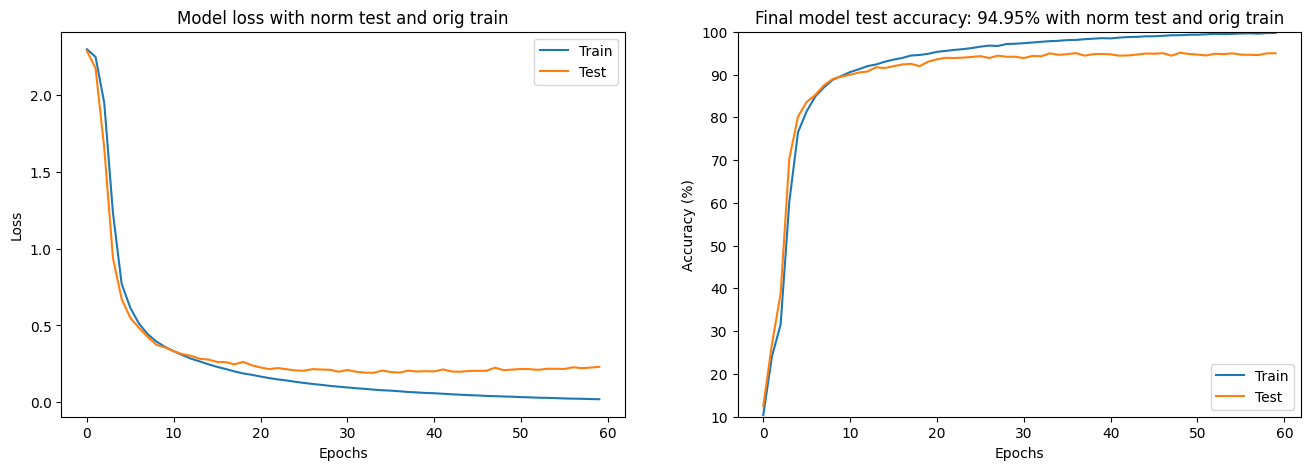

In [31]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim([0,3])
ax[0].legend(['Train','Test'])
ax[0].set_title('Model loss with norm test and orig train')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}% with norm test and orig train')
ax[1].legend()

plt.show();

# Inspect the results

In [ ]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = model(X).detach()

torch.exp(predictions)

tensor([[3.7665e-08, 1.9284e-14, 2.4115e-07,  ..., 9.1806e-08, 8.7618e-07,
         3.6493e-10],
        [6.7922e-06, 8.9397e-07, 5.6222e-04,  ..., 3.0567e-02, 1.3187e-01,
         8.0008e-01],
        [4.8832e-11, 9.9850e-01, 3.0047e-04,  ..., 5.6057e-06, 4.0296e-04,
         1.3926e-07],
        ...,
        [9.2504e-09, 2.0084e-03, 9.9776e-01,  ..., 6.4392e-07, 2.2895e-04,
         1.4347e-12],
        [1.0269e-10, 2.6254e-10, 4.3923e-07,  ..., 9.9998e-01, 2.5313e-07,
         1.6710e-05],
        [2.1575e-10, 3.2980e-14, 1.4895e-07,  ..., 9.6697e-19, 6.3212e-11,
         1.0268e-16]])

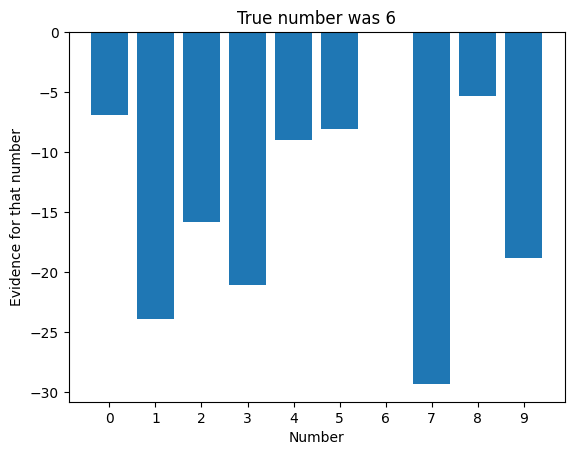

In [ ]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  21   28   34  124  172  179  228  244  247  256  263  292  293  316
  328  332  346  390  395  411  456  493  511  513  517  585  616  648
  669  716  735  797  810  844  852  871  879  888  899  963  974  983
  995 1011 1030 1072 1078 1083 1086 1109 1140 1143 1155 1160 1162 1166
 1191 1199 1200 1210 1240 1295 1345 1381 1399 1456 1480 1506 1512 1536
 1537 1578 1580 1612 1664 1674 1682 1708 1710 1726 1742 1745 1802 1814
 1821 1832 1874 1900 1915 1933 1939 1946 1967 1982 1992 1993]


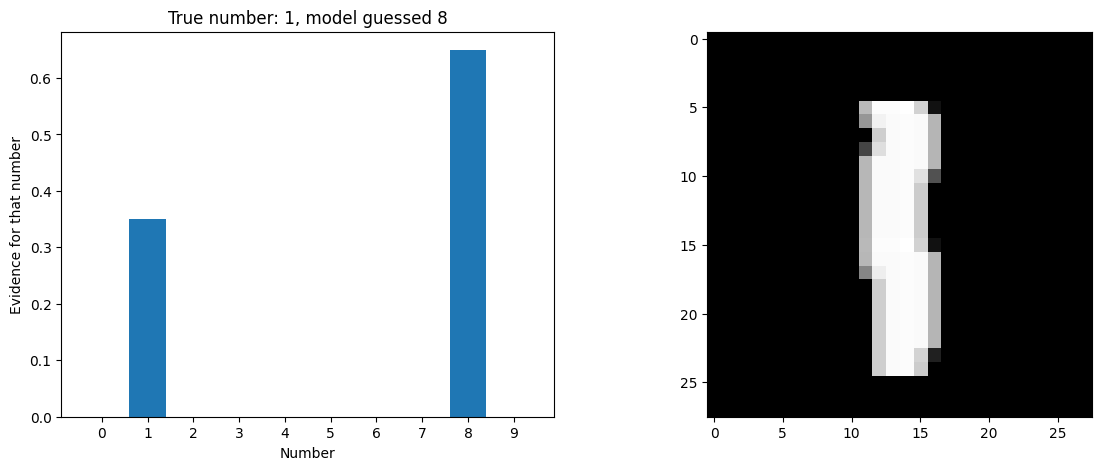

In [ ]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 20

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),torch.exp(predictions[errors[sample2show]]).detach())
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

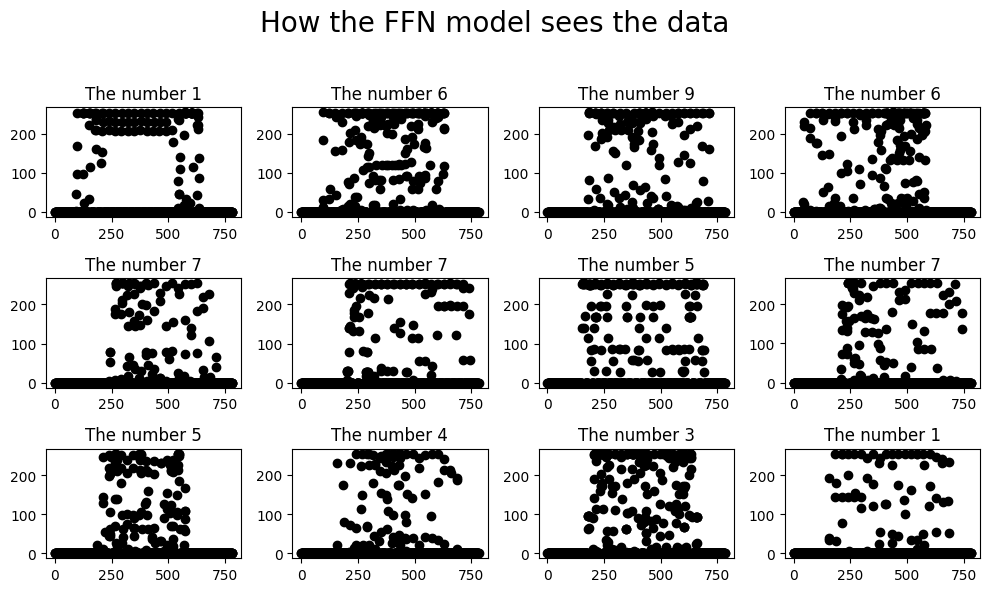

In [ ]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image
  ax.plot(data[randimg2show,:],'ko')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How the FFN model sees the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

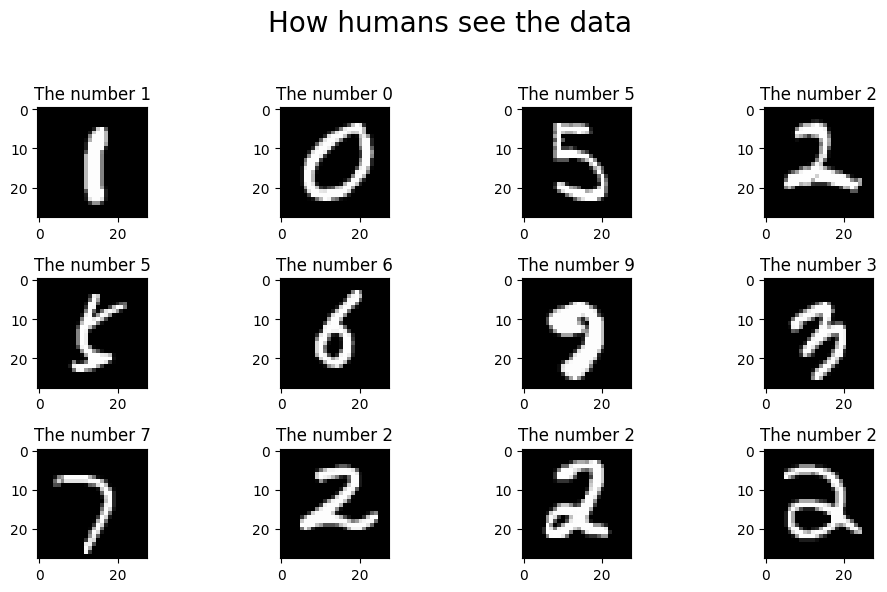

In [ ]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(data[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How humans see the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show();

In [ ]:
np.where(labels==7), np.where(labels==7)[0]

((array([    2,    11,    12, ..., 19937, 19948, 19969]),),
 array([    2,    11,    12, ..., 19937, 19948, 19969]))

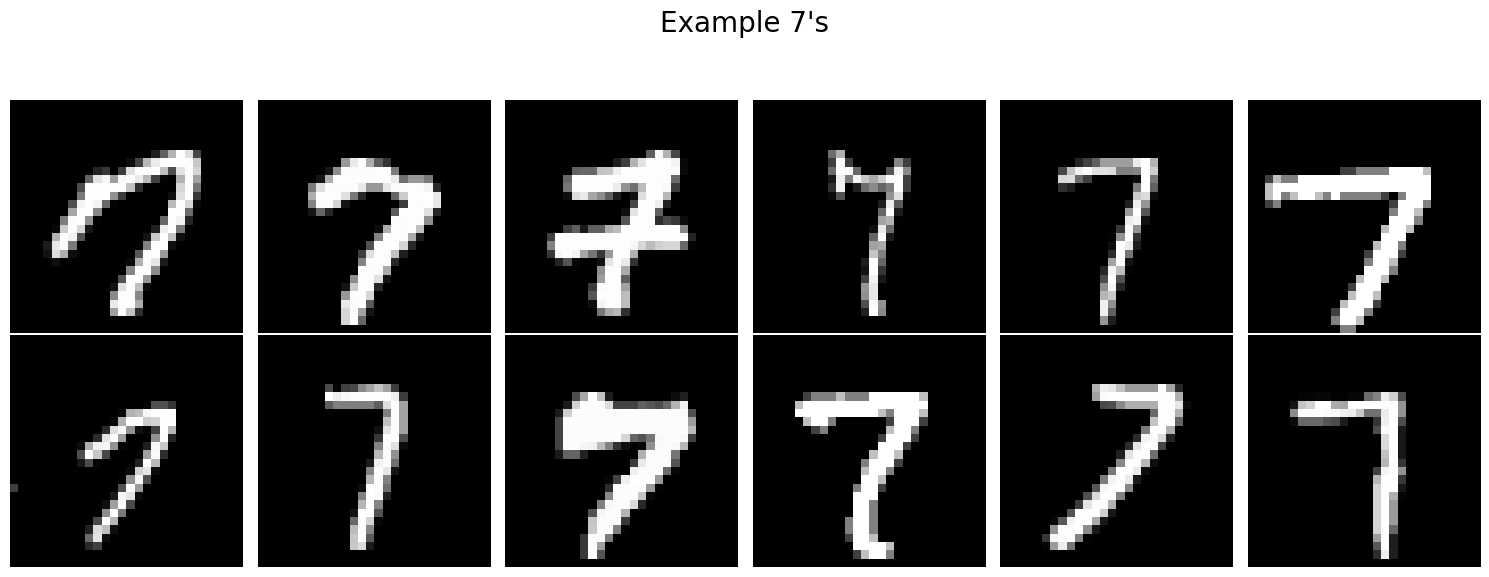

In [ ]:
#  Average together the correct 7's and the error 7's, and make images of them (that is, one image of all correct 7's and one image of all incorrectly labeled 7's).
# let's see some example 7s

# find indices of all the 7's in the dataset
the7s = np.where(labels==7)[0]

# draw the first 12
fig,axs = plt.subplots(2,6,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):
  img = np.reshape(data[the7s[i],:],(28,28))
  ax.imshow(img,cmap='gray')
  ax.axis('off')

plt.suptitle("Example 7's",fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

(2126, 784)


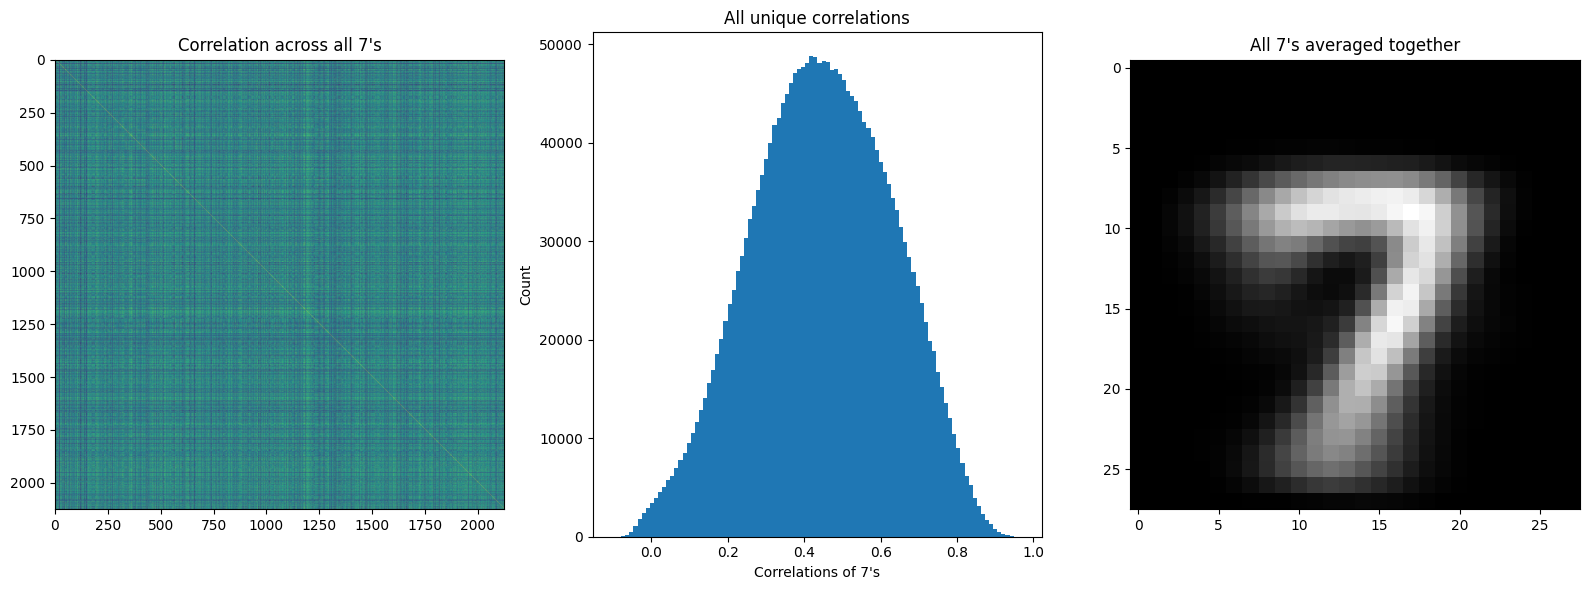

In [ ]:
# how similar are all the 7's?

# how many 7's are there?
print(data[the7s,:].shape)


# let's see how they relate to each other by computing spatial correlations
C = np.corrcoef(data[the7s,:])

# and visualize
fig,ax = plt.subplots(1,3,figsize=(16,6))
ax[0].imshow(C,vmin=0,vmax=1)
ax[0].set_title("Correlation across all 7's")

# extract the unique correlations and show as a scatterplot
uniqueCs = np.triu(C,k=1).flatten()
ax[1].hist(uniqueCs[uniqueCs!=0],bins=100)
ax[1].set_title('All unique correlations')
ax[1].set_xlabel("Correlations of 7's")
ax[1].set_ylabel('Count')

# show all 7's together
aveAll7s = np.reshape( np.mean(data[the7s,:],axis=0) ,(28,28))
ax[2].imshow(aveAll7s,cmap='gray')
ax[2].set_title("All 7's averaged together")

plt.tight_layout()
plt.show();